# Mesh Interpolation Windows

In this notebook we explore the different window options for interpolating discrete objects on to a mesh. We compute the 1D power spectrum $P(k)$ of a density field interpolated from a log-normal mock using different windows. The windows we test are:

- Cloud in Cell: ``cic`` (default in nbodykit)
- Triangular Shaped Cloud: ``tsc``
- [Lanczos Kernel](https://en.wikipedia.org/wiki/Lanczos_resampling) with $a=2$ and $a=3$: ``lanczos2`` and ``lanczos3``
- [Symmetric Daubechies wavelet](https://en.wikipedia.org/wiki/Daubechies_wavelet) with sizes 6, 12, and 20: ``sym6``, ``sym12``, and ``sym20``

We also include timing tests when using each of these windows. The CIC window (default) is the fastest and can be considerably faster than the other kernels, especially the wavelet windows with large sizes. 

When computing the power spectrum $P(k)$, we de-convolve the effects of the interpolation on the measured power (``compensated=True``) for the CIC and TSC windows, but do not apply any corrections for the other windows. 

For more information on using the Daubechies wavelets for power spectrum measurements, see [Cui et al. 2008](https://arxiv.org/abs/0804.0070).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [13]:
from nbodykit.lab import *
from nbodykit import style
from scipy.interpolate import InterpolatedUnivariateSpline as spline

import matplotlib.pyplot as plt
plt.style.use(style.notebook)

## Initalizing a Log-normal Mock

We start by generating a mock catalog of biased objects ($b_1 = 2$ ) at a redshif $z=0.55$. We use the *Planck* 2015 cosmology and the Eisenstein-Hu linear power spectrum fitting formula. We generate the catalog in a box of side length $L = 1380 \ \mathrm{Mpc}/h$ with a constant number density $\bar{n} = 3 \times 10^{-3} \ h^{3} \mathrm{Mpc}^{-3}$.


In [3]:
redshift = 0.55
cosmo = cosmology.Planck15
Plin = cosmology.EHPower(cosmo, redshift)

cat = LogNormalCatalog(Plin=Plin, nbar=3e-4, BoxSize=1380., Nmesh=256, bias=2.0, seed=42)
cat_noise = UniformCatalog(nbar=3e-4, BoxSize=1380., seed=42)

/global/homes/y/yfeng1/.conda/envs/bccp/lib/python3.5/site-packages/nbodykit/cosmology/power/linear.py:228: FutureWarning: NoWiggleEHPower is deprecated. Use LinearPower with transfer set to 'EisensteinHu'
  warnings.warn("NoWiggleEHPower is deprecated. Use LinearPower with transfer set to 'EisensteinHu'", FutureWarning)


## Generating the "Truth"

We generate the "truth" power spectrum by using a higher resolution mesh with ``Nmesh=512``, using the TSC window interpolation method. With a higher resolution mesh, the Nyquist frequency is larger, decreasing the effects of aliasing at a given $k$ value.

In [4]:
r = FFTPower(cat.to_mesh(window='tsc', Nmesh=512, compensated=True), 
            mode='1d') # hi-resolution mesh
truth = r.power
truth = spline(truth['k'], truth['power'].real - truth.attrs['shotnoise'])


The truth power of the shotnoise is just $\frac{1}{\bar{n}}$

In [5]:
truth_noise = lambda k: 0.0 * k + 1 / 3e-4

## Comparing Different Windows / LCDM-like

We compare the results when using different windows to measure a LCDM-like $P(k)$ as compared to the high-resolution "truth" measured in the previous section. The goal is to identify which windows perform better/worse at minimizing this differences. We compute results using a lower-resultion mesh, ``Nmesh=256``. The effects of aliasing are clear: the measured power to differ from the "truth". For CIC and TSC, there is a residuel bias at small scale even after the resampling window has been compensated. This is because the true power-spectrum is LCDM-like, while the compensation window is derived for a shot-noise like signal.

computing power for window 'cic'
--------------------------------
CPU times: user 1.5 s, sys: 64 ms, total: 1.56 s
Wall time: 1.56 s
computing power for window 'tsc'
--------------------------------
CPU times: user 1.5 s, sys: 24.1 ms, total: 1.52 s
Wall time: 1.52 s
computing power for window 'sym6'
--------------------------------
CPU times: user 4.19 s, sys: 35.9 ms, total: 4.22 s
Wall time: 4.22 s
computing power for window 'sym12'
--------------------------------
CPU times: user 9.45 s, sys: 63.7 ms, total: 9.52 s
Wall time: 9.5 s
computing power for window 'sym20'
--------------------------------
CPU times: user 15 s, sys: 56.1 ms, total: 15.1 s
Wall time: 15 s
computing power for window 'lanczos2'
--------------------------------
CPU times: user 2.02 s, sys: 32 ms, total: 2.06 s
Wall time: 2.05 s
computing power for window 'lanczos3'
--------------------------------
CPU times: user 3.26 s, sys: 56 ms, total: 3.32 s
Wall time: 3.32 s


(0.9, 1.1)

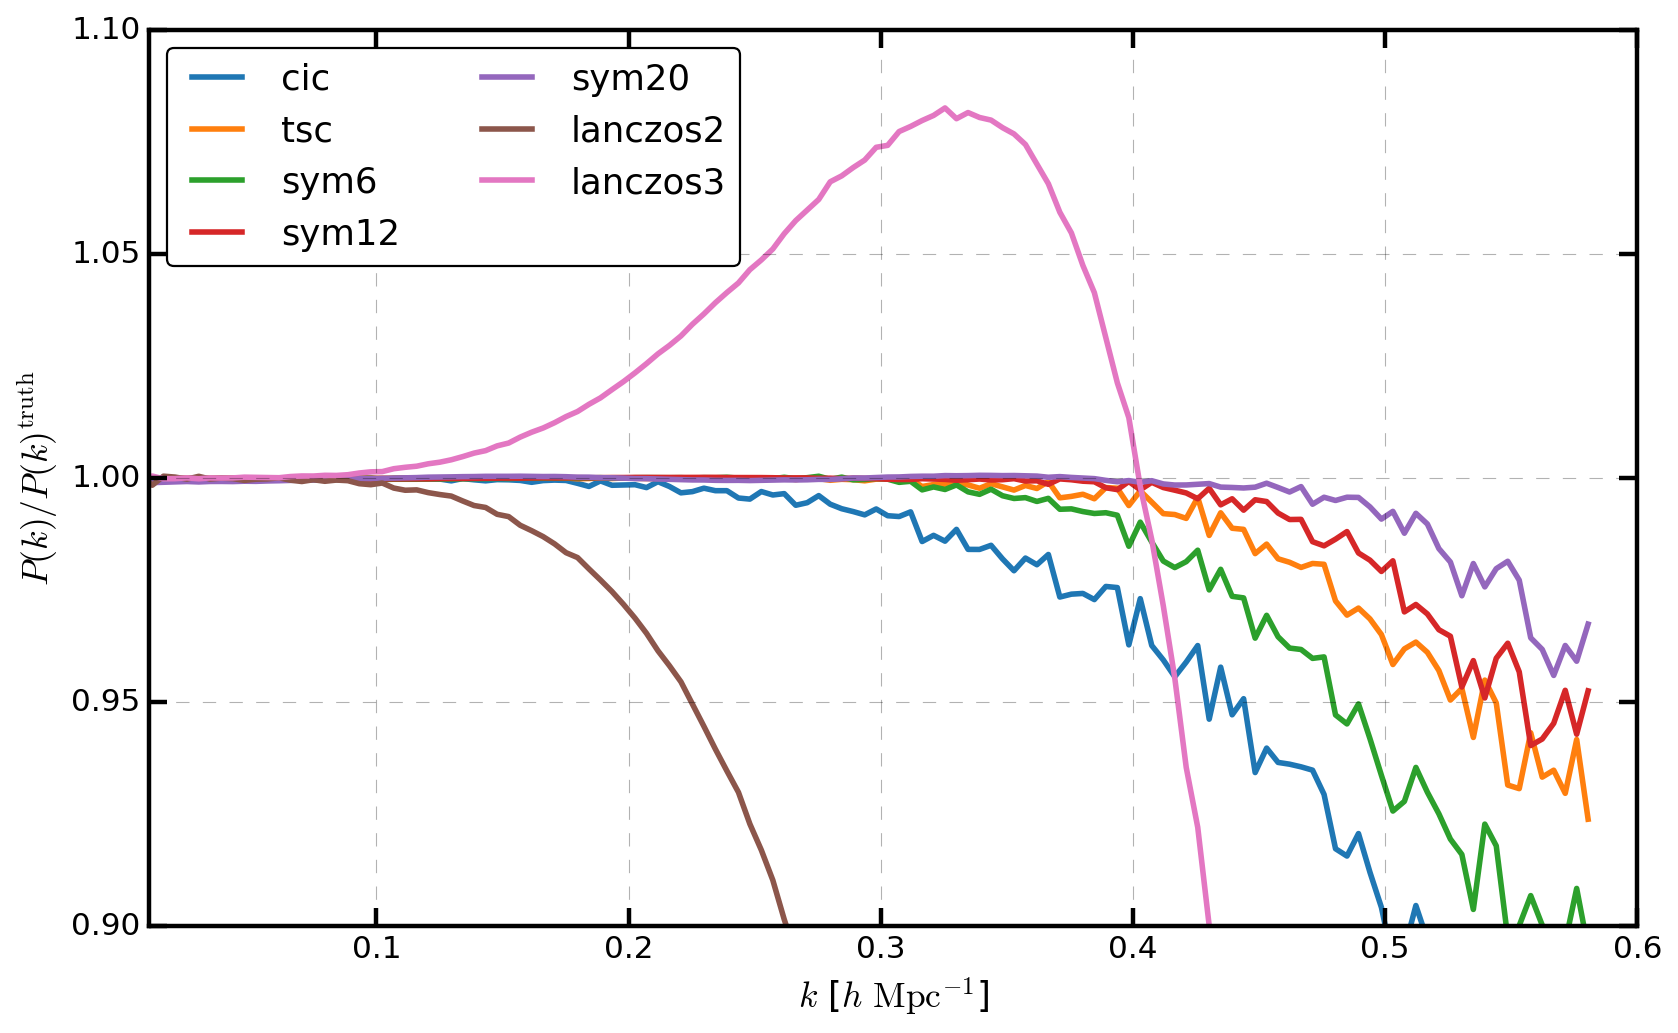

In [18]:
for window in ['cic', 'tsc', 'sym6', 'sym12', 'sym20', 'lanczos2', 'lanczos3']:
    
    print("computing power for window '%s'\n" %window + "-"*32)
    compensated = True if window in ['cic', 'tsc'] else False
    mesh = cat.to_mesh(Nmesh=256, window=window, compensated=compensated, interlaced=False)
    
    # compute the power
    %time r = FFTPower(mesh, mode='1d')
    Pk = r.power
    
    plt.plot(Pk['k'], (Pk['power'].real - Pk.attrs['shotnoise']) / truth(Pk['k']), label=window)
    
plt.legend(loc=0, ncol=2, fontsize=16)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k) / P(k)^\mathrm{truth}$")
plt.xlim(0.01, 0.6)
plt.ylim(0.9, 1.1)

In this figure, we see that each window kernel has a specific $k_\mathrm{max}$ where we can reasonably trust the measured results. The wavelet kernels ``sym12`` and ``sym20`` perform the best but taking over an order magnitude longer to compute than the default kernel (CIC). The Triangular Shaped Cloud window performs the next best, followed by the ``sym6`` kernel and the CIC kernel. The Lanczos kernels do not perform well and should not be used by the user without additional compensation corrections (currently not implemented by default in nbodykit).

## Comparing Different Windows / Shotnoise-like

We compare the results when using different windows to measure a shotnois-like $P(k)$ as compared to the high-resolution "truth" measured in the previous section. We compute results using a lower-resultion mesh, ``Nmesh=256``. The effects of aliasing and resampling is clear: compensation is effective at compensating the 'missing' power, recovering the flat shot-noise power. The wavelet inspired resampling windows also recovers the shot-noise power excellently. The lanczos based windows perform relatively badly due to a lack of suitable compensation function.

computing power for window 'cic'
--------------------------------
CPU times: user 1.6 s, sys: 28 ms, total: 1.63 s
Wall time: 1.63 s
computing power for window 'tsc'
--------------------------------
CPU times: user 1.8 s, sys: 36 ms, total: 1.83 s
Wall time: 1.83 s
computing power for window 'sym6'
--------------------------------
CPU times: user 6.84 s, sys: 44.1 ms, total: 6.88 s
Wall time: 6.87 s
computing power for window 'sym12'
--------------------------------
CPU times: user 15.5 s, sys: 108 ms, total: 15.7 s
Wall time: 15.6 s
computing power for window 'sym20'
--------------------------------
CPU times: user 23 s, sys: 160 ms, total: 23.2 s
Wall time: 23.2 s
computing power for window 'lanczos2'
--------------------------------
CPU times: user 2.89 s, sys: 52 ms, total: 2.94 s
Wall time: 2.94 s
computing power for window 'lanczos3'
--------------------------------
CPU times: user 5.32 s, sys: 56 ms, total: 5.38 s
Wall time: 5.37 s


(0.9, 1.1)

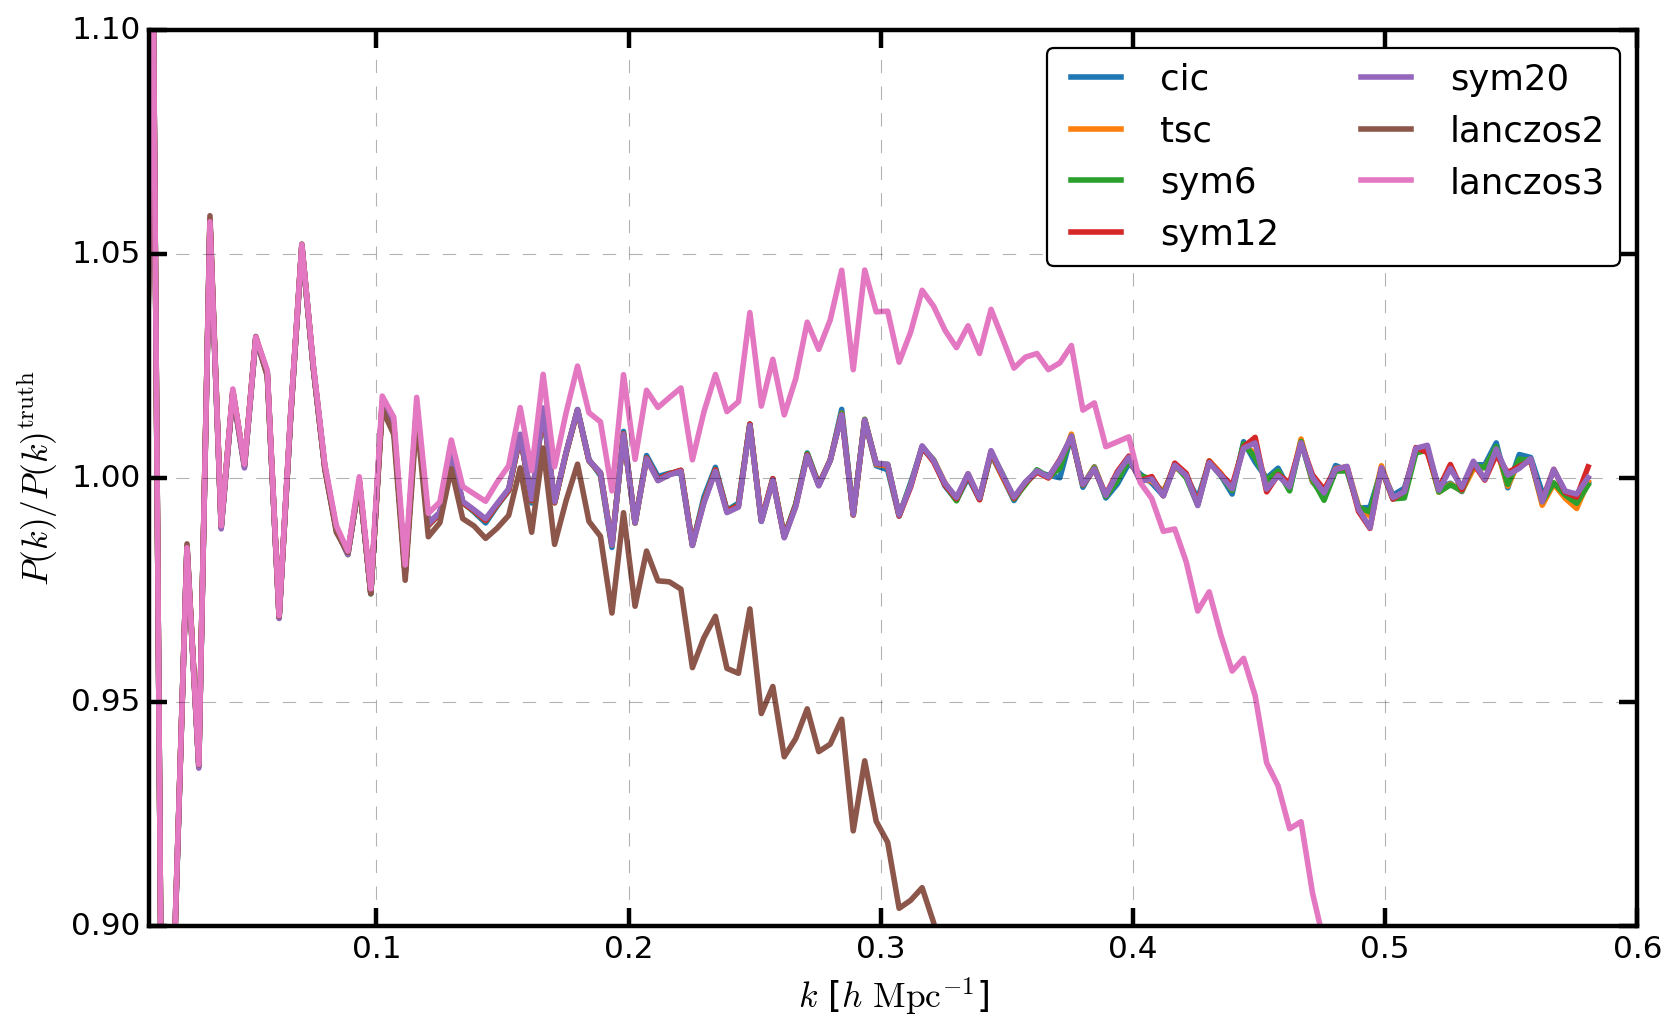

In [19]:
for window in ['cic', 'tsc', 'sym6', 'sym12', 'sym20', 'lanczos2', 'lanczos3']:
    
    print("computing power for window '%s'\n" %window + "-"*32)
    compensated = True if window in ['cic', 'tsc'] else False
    mesh = cat_noise.to_mesh(Nmesh=256, window=window, compensated=compensated, interlaced=False)
    
    # compute the power
    %time r = FFTPower(mesh, mode='1d')
    Pk = r.power
    
    plt.plot(Pk['k'], (Pk['power'].real) / truth_noise(Pk['k']), label=window)
    
plt.legend(loc=0, ncol=2, fontsize=16)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k) / P(k)^\mathrm{truth}$")
plt.xlim(0.01, 0.6)
plt.ylim(0.9, 1.1)

**Recommendations** 

Given the increased speed costs of the wavelet windows, we recommend users use either the CIC or TSC windows. For optimized solutions providing the most precise results in the fastest amount of time, users should test the effects of setting ``interlaced=True`` ([see this tutorial](interlacing.ipynb)) while also trying various mesh sizes by changing the ``Nmesh`` parameter. The most robust results are obtained by running a series of convergence tests by computing results with a high-resolution mesh, which reduces the contributions of aliasing at fixed $k$. This allows the user to robustly determine the best configuration for their desired accuracy. 